# Data 
Source: 'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'

Goal:    **Model email topics**

Explanations and theory: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Load data and python libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('max_colwidth',150)

import numpy as np
import collections

# text processing libraries
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_md 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = en_core_web_md.load(disable=['parser', 'ner'])

# topic modeling libraries
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim 

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# progress meter for loops
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

print('\nDataset size:', df.shape)
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']

Dataset size: (11314, 3)


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Marylan...,7,rec.autos
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,accele...",4,comp.sys.mac.hardware
10,"From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: What's it worth?\nDistribution: usa\nExpires: Sat, ...",8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen)\nSubject: ** Software forsale (lots) **\nNntp-Posting-Host: magnusug.magnus.acs.ohio-state....,6,misc.forsale
1000,"From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\nSubject: Diamond SS24X, Win 3.1, Mouse cursor\nOrganization: National Library of Medicine\nLines: 10...",2,comp.os.ms-windows.misc


# Data cleaning and preparations

In [3]:
# data for analysis
df = df[df['content'].isnull() == False]
len(df)

11314

In [4]:
# content text example
print(df['content'].iloc[104])

From: markm@bigfoot.sps.mot.com (Mark Monninger)
Subject: Re: No-Haggle Deals...Save $$???
Nntp-Posting-Host: 223.250.10.7
Reply-To: rapw20@email.sps.mot.com
Organization: SPS
Distribution: usa
Lines: 3

You can be sure they wouldn't do it if it wasn't to their advantage.

Mark



In [5]:
df['content'].iloc[104]

"From: markm@bigfoot.sps.mot.com (Mark Monninger)\nSubject: Re: No-Haggle Deals...Save $$???\nNntp-Posting-Host: 223.250.10.7\nReply-To: rapw20@email.sps.mot.com\nOrganization: SPS\nDistribution: usa\nLines: 3\n\nYou can be sure they wouldn't do it if it wasn't to their advantage.\n\nMark\n"

In [6]:
print('Every email has subject:')
df['content'].str.contains('Subject: ').value_counts()

Every email has subject:


True    11314
Name: content, dtype: int64

In [7]:
# extract Subject of each email
df['subject'] = df['content'].str.split('Subject: ').str.get(1)
df['subject'] = df['subject'].str.replace(r'\n+.+','')
print('Extracted subject example:\n', '='*30 + '\n', df['subject'].iloc[104])
print('='*30)

#check that all subjects where extracted
print('An email has extracted subject:')
(df['subject'].isnull() == False).value_counts()

Extracted subject example:
 Re: No-Haggle Deals...Save $$???

An email has extracted subject:


True    11314
Name: subject, dtype: int64

In [8]:
# extract text of each email
print('Every email has words "Lines: ":')
df['content'].str.contains('Lines: ').value_counts()

Every email has words "Lines: ":


True     11276
False       38
Name: content, dtype: int64

In [9]:
# extract text of each email
df['text'] = df['content'].str.split(r'Lines: \d+').str.get(1)
print('Extracted subject example:\n', '='*30 + '\n', df['text'].iloc[104])
print('='*30)

#check that all texts where extracted
print('An email has extracted text:')
(df['text'].isnull() == False).value_counts()

Extracted subject example:
 

You can be sure they wouldn't do it if it wasn't to their advantage.

Mark

An email has extracted text:


True     11273
False       41
Name: text, dtype: int64

In [10]:
# delete records with no extracted text of email
df = df[df['text'].isnull() == False]
len(df)

11273

In [11]:
# spot check
print(df[df['text'].str.contains('@') == True]['text'].iloc[0])


NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [12]:
# additional text cleaning

# remove text related to "Posting-Host"
df['text'] = df['text'].str.replace(r'NNTP-Posting-Host: \S*\s?', '', re.I)

# remove Emails
df['text'] = df['text'].str.replace(r'\S*@\S*\s?', '')

# remove new line characters
df['text'] = df['text'].str.replace(r'\s+', ' ')

# remove single quotes
df['text'] = df['text'].str.replace(r"\'", '')

In [13]:
# spot check
print('Message text contains emails:')
df['text'].str.contains('@').value_counts()

Message text contains emails:


False    11273
Name: text, dtype: int64

In [14]:
# add message subject to the message text for topic modeling
df['text'] = df['subject'] + '\n' + df['text']

In [15]:
# review text length analysis
df['Text Length in Characters'] = df['text'].apply(len)

print("Text Length in Characters:")
df['Text Length in Characters'].describe()

Text Length in Characters:


count    11273.000000
mean      1605.498359
std       3437.286153
min          7.000000
25%        535.000000
50%        919.000000
75%       1574.000000
max      64788.000000
Name: Text Length in Characters, dtype: float64

In [16]:
del df['Text Length in Characters']

In [17]:
df_data = df.copy()

# Data preprocessing

In [18]:
# create spacy "nlp" object
df_data['doc'] = df_data['text'].apply(lambda x: nlp(x))

# delete stop words, select POSs that are letters and correspond to words with at least 3 characters 
df_data['list_of_POSs'] = df_data['doc'].apply(lambda x: [word.pos_
                                    for word in x if (word.is_stop==False) & (len(word.text)>2) & (word.is_alpha)])

##### Selecting most informative POSs by total frequencies

In [19]:
# POS is more about the context of the features than frequencies of features

# get all POSs in each review in a list
tmp_list = df_data['list_of_POSs'].tolist()
list_of_POSs = [POS for sublist in tmp_list for POS in sublist]

#count POSs' total frequencies in the corpus
POS_freq_counter = collections.Counter(list_of_POSs)
s_POS_freq = pd.Series(POS_freq_counter)

#sort POSs document frequencies in the corpus 
s_tmp = s_POS_freq.sort_values(ascending=False)

print('Total number of POSs: ', len(set(s_POS_freq)))
print('POS = ADP means conjunction, subordinating or preposition')
print('POS = INTJ means interjection')
pd.DataFrame(s_tmp, columns=['Frequency'])

Total number of POSs:  16
POS = ADP means conjunction, subordinating or preposition
POS = INTJ means interjection


,Frequency
NOUN,531906
VERB,280760
PROPN,269443
ADJ,156607
ADV,44235
ADP,5711
INTJ,5221
X,3545
NUM,1233
CCONJ,380


In [20]:
# selecting POSs
selected_POSs = ['NOUN', 'VERB', 'ADJ', 'ADV']

print('selecting POSs:')
selected_POSs 

selecting POSs:


['NOUN', 'VERB', 'ADJ', 'ADV']

##### Selecting most informative lemmas

In [21]:
# lemmatize words with selected POSs, 
# lemmas that are not stop-words and have at least 3 characters
df_data['list_of_lemmas'] = df_data['doc'].apply(lambda x: [word.lemma_
                                                                for word in x if (word.is_stop==False) & \
                                                                                 (len(word.text)>2) & \
                                                                                 (word.is_alpha) & \
                                                                                 (word.pos_ in selected_POSs)])

In [22]:
# example of an email
ind = 3

print(df_data['text'].iloc[ind])
print('\n#Lemmas:\n')
print(df_data['list_of_lemmas'].iloc[ind])

set_POSs = set(df_data['list_of_POSs'].apply(set).iloc[ind])
print('\n#POSs:\n')
print(set_POSs)
print('Only lemmas with POSs:', set_POSs & set(selected_POSs), ' were selected')

** Software forsale (lots) **

 1. Software publishing SuperBase 4 windows v.1.3 --->$80 2. OCR System ReadRight v.3.1 for Windows --->$65 3. OCR System ReadRight v.2.01 for DOS --->$65 4. Unregistered Zortech 32 bit C++ Compiler v.3.1 --->$ 250 with Multiscope windows Debugger, WhiteWater Resource Toolkit, Library Source Code 5. Glockenspiel/ImageSoft Commonview 2 Windows Applications Framework for Borland C++ --->$70 6. Spontaneous Assembly Library With Source Code --->$50 7. Microsoft Macro Assembly 6.0 --->$50 8. Microsoft Windows v.3.1 SDK Documentation --->$125 9. Microsoft FoxPro V.2.0 --->$75 10. WordPerfect 5.0 Developers Toolkit --->$20 11. Kedwell Software DataBoss v.3.5 C Code Generator --->$100 12. Kedwell InstallBoss v.2.0 Installation Generator --->$35 13. Liant Software C++/Views v.2.1 Windows Application Framework with Source Code --->$195 14. IBM OS/2 2.0 & Developers Toolkit --->$95 15. CBTree DOS/Windows Library with Source Code --->$120 16. Symantec TimeLine for Wi

In [23]:
# reducing dimensionality of word dictionary in LDA model
# deleting too frequent and too infrequent lemmas based on document frequency

# get all unique lemmas from each review in a list
tmp_list = df_data['list_of_lemmas'].apply(set).apply(list).tolist()
list_of_lemmas = [lemma for sublist in tmp_list for lemma in sublist]

# count lemmas' document frequencies in the corpus
lemma_freq_counter = collections.Counter(list_of_lemmas)
s_lemma_freq = pd.Series(lemma_freq_counter)

# analyze lemmas' document frequencies in the corpus 
s_tmp = s_lemma_freq.sort_values(ascending=False)
df_tmp = pd.DataFrame({'Most freq words': list(s_tmp.index[:20]),
                       'M_freq': list(s_tmp.iloc[:20]),
                       'Least freq words': list(s_tmp.index[-20:]),
                       'L_freq': list(s_tmp.iloc[-20:])})

print('Total number of unique lemmas: ', len(s_lemma_freq))
print ("\nDistribution of lemmas' document counts: ")
print(s_lemma_freq.describe(percentiles=[0.55, 0.65, 0.75, 0.85, 0.95, 0.97, 0.99]))
df_tmp

Total number of unique lemmas:  32205

Distribution of lemmas' document counts: 
count    32205.000000
mean        21.334451
std        109.287340
min          1.000000
50%          2.000000
55.0%        2.000000
65%          4.000000
75%          7.000000
85%         16.400000
95%         82.000000
97%        145.000000
99%        395.960000
max       6470.000000
dtype: float64


,Most freq words,M_freq,Least freq words,L_freq
0,write,6470,cum,1
1,article,4930,woodlouse,1
2,know,3799,crumenam,1
3,think,3242,populum,1
4,good,2789,ignorantium,1
5,time,2695,EXTENDED,1
6,people,2455,arguer,1
7,use,2366,falseness,1
8,want,2307,equivocation,1
9,work,2244,having,1


In [24]:
# select lemmas 
up_pst = 500 #s_lemma_freq.quantile(0.99)
low_pst = 3 #s_lemma_freq.quantile(0.50)

selected_lemmas = set(s_lemma_freq[(s_lemma_freq > low_pst)&(s_lemma_freq < up_pst)].index)
print ('Upper bound for lemma document frequency: ', up_pst)
print ('Lower bound for lemma document frequency: ', low_pst)
print('Number of selected lemmas: ', len(selected_lemmas))

print("\nExample of selected lemmas:")
list(selected_lemmas)[:5]

Upper bound for lemma document frequency:  500
Lower bound for lemma document frequency:  3
Number of selected lemmas:  11810

Example of selected lemmas:


['doc', 'tote', 'inhale', 'strictly', 'destructive']

In [25]:
# select lemmas in each document if they belong to chosen list of lemmas
df_data['selected_list_of_lemmas'] = df_data['list_of_lemmas'].apply(lambda x: 
                                                                     [l for l in x if l in selected_lemmas])

In [26]:
# example of an email
ind = 3

print(df_data['text'].iloc[ind])
print('\n#Selected lemmas:\n')
print(df_data['selected_list_of_lemmas'].iloc[ind])

** Software forsale (lots) **

 1. Software publishing SuperBase 4 windows v.1.3 --->$80 2. OCR System ReadRight v.3.1 for Windows --->$65 3. OCR System ReadRight v.2.01 for DOS --->$65 4. Unregistered Zortech 32 bit C++ Compiler v.3.1 --->$ 250 with Multiscope windows Debugger, WhiteWater Resource Toolkit, Library Source Code 5. Glockenspiel/ImageSoft Commonview 2 Windows Applications Framework for Borland C++ --->$70 6. Spontaneous Assembly Library With Source Code --->$50 7. Microsoft Macro Assembly 6.0 --->$50 8. Microsoft Windows v.3.1 SDK Documentation --->$125 9. Microsoft FoxPro V.2.0 --->$75 10. WordPerfect 5.0 Developers Toolkit --->$20 11. Kedwell Software DataBoss v.3.5 C Code Generator --->$100 12. Kedwell InstallBoss v.2.0 Installation Generator --->$35 13. Liant Software C++/Views v.2.1 Windows Application Framework with Source Code --->$195 14. IBM OS/2 2.0 & Developers Toolkit --->$95 15. CBTree DOS/Windows Library with Source Code --->$120 16. Symantec TimeLine for Wi

# Create document-term matrix for the LDA model 

In [27]:
# create a vocabulary for the LDA model 
dictionary = corpora.Dictionary(df_data['selected_list_of_lemmas'])

In [28]:
print('Number of texts processed: ', dictionary.num_docs)
print('Number of extracted tokens/words: ', len(dictionary.token2id))
print('\nEach text is represented by list of ', len(dictionary.token2id), 
      " tuples: \n\t\t(token's index in bag-of-words dictionary, token's term frequency)")

Number of texts processed:  11273
Number of extracted tokens/words:  11810

Each text is represented by list of  11810  tuples: 
		(token's index in bag-of-words dictionary, token's term frequency)


In [29]:
# count the number of occurrences of each distinct token in each document
df_data['doc2bow'] = df_data['selected_list_of_lemmas'].apply(lambda x: dictionary.doc2bow(x))
df_data[['selected_list_of_lemmas','doc2bow']].head()

,selected_list_of_lemmas,doc2bow
0,"[enlighten, sport, late, early, door, addition, bumper, separate, rest, body, model, engine, spec, production, history, funky, neighborhood]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]"
1,"[fair, brave, soul, upgrade, clock, oscillator, share, poll, brief, detail, procedure, speed, attain, cpu, rate, speed, adapter, heat, sink, hour,...","[(17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (..."
10,"[recommendation, model, clock, paint, bronze, brown, orange, fade, leak, oil, pop, accel, shop, fix, tran, oil, leak, bike, owner, nice, stable, m...","[(10, 1), (21, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 2), (58, 1), (..."
100,"[forsale, publish, unregistered, spontaneous, documentation, installation, negotiable]","[(66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1)]"
1000,"[diamond, cursor, Anybody, mouse, cursor, distortion, driver, driver, indication, menu, recently, deliver, late, driver]","[(9, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 3), (79, 1), (80, 1), (81, 1), (82, 1)]"


In [30]:
# create document-term matrix for LDA
doc_term_matrix = list(df_data['doc2bow'].values)

# Estimate the number of topics in a corpus (through topic coherence)

In [31]:
LDA = models.LdaMulticore
num_topics_list = np.arange(3,36)

coherenceList_cv = []


# for each number of topics calculate Coherence Score
for num_topics in tqdm(num_topics_list):
    #LDA model
    lda= LDA(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=20,chunksize=4000,random_state=3,workers=2)
    
    #C_v coherence score
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=df_data['selected_list_of_lemmas'], dictionary=dictionary, coherence='c_v')
    
    #append model coherence value 
    coherenceList_cv.append(cm_cv.get_coherence())

100%|██████████| 33/33 [44:35<00:00, 84.97s/it]


Text(0.5, 1.05, 'Topic Coherence\n  C_v Score')

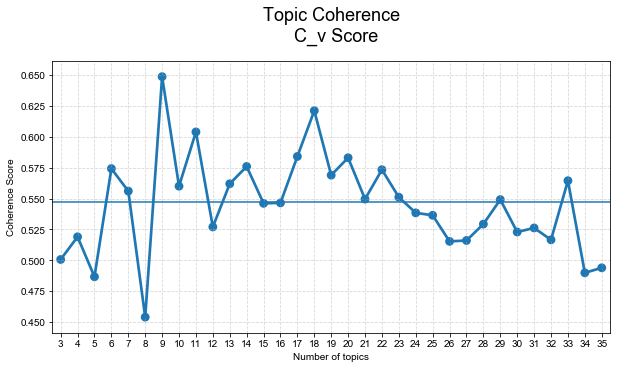

In [32]:
df_plot = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence Score':coherenceList_cv})
f, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-whitegrid')

sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})
sns.pointplot(x ='Number of topics', y = 'Coherence Score', data=df_plot)

plt.axhline(y=0.547)

ax.grid(True, ls='--', alpha=0.5)
plt.title('Topic Coherence\n  C_v Score', y=1.05, fontsize=18)

# Define multicore LDA model

In [33]:
# define the model with chosen number of topics
num_topics = 15


LDA = models.LdaMulticore
result_lda_model= LDA(corpus=doc_term_matrix, 
               num_topics=num_topics,
               id2word = dictionary, 
               passes=20,
               chunksize=4000,
               random_state=3)

In [34]:
# compute estimated Coherence Score
coherence_model_lda = CoherenceModel(model=result_lda_model, 
                                     corpus=doc_term_matrix,
                                     texts=df_data['selected_list_of_lemmas'], 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5442771519896923


##### Interactive visualization of topics using pyLDAviz

In [35]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(result_lda_model, doc_term_matrix, dictionary,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.165173 -0.009006       1        1   9.890977
1      0.210323 -0.086305       2        1  11.468851
2      0.027332  0.092841       3        1   5.261434
3      0.035697 -0.014281       4        1   5.317089
4     -0.126074  0.014067       5        1   8.836576
5      0.207948  0.001581       6        1   5.144166
6      0.102243 -0.096670       7        1   6.921495
7      0.062263  0.126715       8        1   6.011788
8     -0.125939  0.202763       9        1   3.704818
9     -0.101050 -0.138454      10        1   3.602279
10    -0.148983 -0.105547      11        1   9.638062
11    -0.102006  0.009523      12        1   6.920092
12     0.073450  0.020449      13        1   3.924374
13    -0.044227 -0.108581      14        1   8.099174
14     0.094196  0.090905      15        1   5.258832, topic_info=     Category         Freq        Term        Total  loglift  logprob
2152  Default  3855.000000         max  3855.000000  30.0000  30.0000
1217  Default  1359.000000         gun  1359.000000  29.0000  29.0000
1908  Default   906.000000      player   906.000000  28.0000  28.0000
46    Default   684.000000        bike   684.000000  27.0000  27.0000
78    Default  1030.000000      driver  1030.000000  26.0000  26.0000
1427  Default  1152.000000        chip  1152.000000  25.0000  25.0000
1083  Default   620.000000      season   620.000000  24.0000  24.0000
24    Default   983.000000        disk   983.000000  23.0000  23.0000
1276  Default   586.000000      weapon   586.000000  22.0000  22.0000
41    Default   884.000000       speed   884.000000  21.0000  21.0000
1020  Default  1077.000000       image  1077.000000  20.0000  20.0000
1045  Default  1022.000000       space  1022.000000  19.0000  19.0000
427   Default   952.000000       human   952.000000  18.0000  18.0000
2335  Default   462.000000  controller   462.000000  17.0000  17.0000
326   Default   766.000000  encryption   766.000000  16.0000  16.0000
874   Default   476.000000        food   476.000000  15.0000  15.0000
848   Default   529.000000       entry   529.000000  14.0000  14.0000
145   Default   552.000000       crime   552.000000  13.0000  13.0000
2373  Default   350.000000     firearm   350.000000  12.0000  12.0000
2408  Default   472.000000         bus   472.000000  11.0000  11.0000
850   Default   629.000000     monitor   629.000000  10.0000  10.0000
268   Default   465.000000        ride   465.000000   9.0000   9.0000
382   Default   572.000000       board   572.000000   8.0000   8.0000
2970  Default   633.000000     turkish   633.000000   7.0000   7.0000
845   Default   843.000000       color   843.000000   6.0000   6.0000
1696  Default   633.000000     israeli   633.000000   5.0000   5.0000
2434  Default   760.000000      server   760.000000   4.0000   4.0000
1104  Default   735.000000      memory   735.000000   3.0000   3.0000
2896  Default   554.000000    armenian   554.000000   2.0000   2.0000
1641  Default   686.000000    religion   686.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2291  Topic15   206.980194        shot   328.187958   2.4843  -5.0771
2365  Topic15   103.990334         amp   152.780411   2.5606  -5.7654
7533  Topic15    33.103584       skate    41.251717   2.7252  -6.9100
2763  Topic15    63.801182      goalie    90.258339   2.5984  -6.2539
159   Topic15   140.656021     penalty   239.022217   2.4150  -5.4634
1078  Topic15   256.756805        goal   513.435242   2.2523  -4.8616
1981  Topic15   122.190407     clipper   206.942810   2.4184  -5.6041
2692  Topic15   104.090775         tap   175.188263   2.4247  -5.7644
2909  Topic15    73.221741         cap   115.422371   2.4902  -6.1162
759   Topic15   216.007675      period   537.355042   2.0339  -5.0344
2472  Topic15   197.125992        pick   500.473206   2.0136  -5.1258
4433  Topic15   103.171722   

##### spot cheks

In [36]:
def top_topic(doc2bow, lda_model):
    print('='*100)
    for index, score in sorted(lda_model[doc2bow], key=lambda tup: -1*tup[1]):
        print("Score: ", round(score, 2)," Topic: ", result_lda_model.print_topic(index, 7))

In [37]:
ind = 30

doc2bow = df_data['doc2bow'].iloc[ind]

print( df_data['text'].iloc[ind], '\n\n')
top_topic(doc2bow, result_lda_model)

Re: Is MSG sensitivity superstition?

 Distribution: world In article (Doug Bank) writes: |> |> Here is another anecdotal story. I am a picky eater and never wanted to |> try chinese food, however, I finally tried some in order to please a |> girl I was seeing at the time. I had never heard of Chinese restaurant |> syndrome. A group of us went to the restaurant and all shared 6 different |> dishes. It didnt taste great, but I decided it wasnt so bad. We went |> home and went to bed early. I woke up at 2 AM and puked my guts outs. |> I threw up for so long that (Im not kidding) I pulled a muscle in |> my tongue. Dry heaves and everything. No one else got sick, and Im |> not allergic to anything that I know of. |> |> Suffice to say that I wont go into a chinese restaurant unless I am |> physically threatened. The smell of the food makes me ill (and that *is* |> a psycholgical reaction). When I have been dragged in to suffer |> through beef and broccoli without any sauces, I insist on no 

# Find the most representative document for each topic

In [38]:
# get topic ID and corresponding topic words
number_of_topic_words = 20

dict_topics = dict(result_lda_model.show_topics(num_topics=num_topics,formatted=False,num_words=number_of_topic_words))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x + 1))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))
df_topics

,topic,topic words
0,Topic 1,"['israeli', 'war', 'human', 'member', 'anti', 'child', 'political', 'turkish', 'murder', 'action', 'fire', 'death', 'arab', 'jewish', 'land', 'arm..."
1,Topic 2,"['image', 'color', 'display', 'server', 'application', 'disk', 'format', 'screen', 'user', 'package', 'graphic', 'code', 'widget', 'font', 'datum'..."
2,Topic 3,"['player', 'season', 'monitor', 'hit', 'score', 'fan', 'baseball', 'league', 'record', 'average', 'ball', 'stat', 'ground', 'pitch', 'tie', 'major..."
3,Topic 4,"['launch', 'algorithm', 'security', 'market', 'secret', 'chip', 'private', 'encryption', 'encrypt', 'space', 'commercial', 'moon', 'company', 'sec..."
4,Topic 5,"['armenian', 'turkish', 'job', 'attack', 'tax', 'city', 'village', 'russian', 'child', 'american', 'israeli', 'official', 'health', 'continue', 'c..."
5,Topic 6,"['driver', 'controller', 'speed', 'bus', 'board', 'chip', 'disk', 'scsi', 'ram', 'memory', 'mode', 'video', 'fast', 'motherboard', 'rom', 'rate', ..."
6,Topic 7,"['space', 'entry', 'orbit', 'copy', 'launch', 'mission', 'section', 'project', 'test', 'satellite', 'return', 'rule', 'author', 'output', 'object'..."
7,Topic 8,"['bike', 'ride', 'engine', 'speed', 'light', 'road', 'mile', 'dog', 'motorcycle', 'tire', 'oil', 'driver', 'dealer', 'brake', 'wheel', 'radar', 'f..."
8,Topic 9,"['max', 'gun', 'weapon', 'firearm', 'crime', 'criminal', 'handgun', 'rate', 'carry', 'self', 'police', 'homicide', 'safety', 'death', 'defense', '..."
9,Topic 10,"['food', 'human', 'moral', 'atheist', 'effect', 'eat', 'animal', 'msg', 'religion', 'morality', 'belief', 'study', 'diet', 'vote', 'nature', 'sens..."


In [39]:
# get topic words and topic average coherence score
list_tmp = result_lda_model.top_topics(doc_term_matrix, dictionary=dictionary, topn=number_of_topic_words, 
                                       coherence='c_v', texts=df_data['list_of_lemmas'])
list_tmp = [(s,wd) for (wd, s) in list_tmp]
dict_scores = dict(list_tmp)
df_scores = pd.DataFrame({'topic coherence score': list(dict_scores.keys()), 
                          'topic words': list(dict_scores.values())}, index=range(len(dict_scores)))
df_scores['topic words'] = df_scores['topic words'].apply(lambda x: str(list(dict(x).values())))
df_scores.head()

,topic coherence score,topic words
0,0.807277,"['driver', 'controller', 'speed', 'bus', 'board', 'chip', 'disk', 'scsi', 'ram', 'memory', 'mode', 'video', 'fast', 'motherboard', 'rom', 'rate', ..."
1,0.750944,"['image', 'color', 'display', 'server', 'application', 'disk', 'format', 'screen', 'user', 'package', 'graphic', 'code', 'widget', 'font', 'datum'..."
2,0.699479,"['player', 'season', 'monitor', 'hit', 'score', 'fan', 'baseball', 'league', 'record', 'average', 'ball', 'stat', 'ground', 'pitch', 'tie', 'major..."
3,0.686363,"['max', 'gun', 'weapon', 'firearm', 'crime', 'criminal', 'handgun', 'rate', 'carry', 'self', 'police', 'homicide', 'safety', 'death', 'defense', '..."
4,0.683801,"['god', 'faith', 'truth', 'christian', 'church', 'religion', 'sin', 'belief', 'die', 'scripture', 'death', 'absolute', 'act', 'choose', 'save', 't..."


In [40]:
# add topic score to the df_topics to distinguish between human interpretable topics and jargons of statistical analysis
# higher the topic coherence, the topic is more human interpretable. 
print('Can assign names to the topics based on the words related to each topic:')
df_topics = df_topics.merge(df_scores, on='topic words')
df_topics.sort_values(by='topic coherence score',ascending=False,inplace=True)
df_topics

Can assign names to the topics based on the words related to each topic:


,topic,topic words,topic coherence score
5,Topic 6,"['driver', 'controller', 'speed', 'bus', 'board', 'chip', 'disk', 'scsi', 'ram', 'memory', 'mode', 'video', 'fast', 'motherboard', 'rom', 'rate', ...",0.807277
1,Topic 2,"['image', 'color', 'display', 'server', 'application', 'disk', 'format', 'screen', 'user', 'package', 'graphic', 'code', 'widget', 'font', 'datum'...",0.750944
2,Topic 3,"['player', 'season', 'monitor', 'hit', 'score', 'fan', 'baseball', 'league', 'record', 'average', 'ball', 'stat', 'ground', 'pitch', 'tie', 'major...",0.699479
8,Topic 9,"['max', 'gun', 'weapon', 'firearm', 'crime', 'criminal', 'handgun', 'rate', 'carry', 'self', 'police', 'homicide', 'safety', 'death', 'defense', '...",0.686363
10,Topic 11,"['god', 'faith', 'truth', 'christian', 'church', 'religion', 'sin', 'belief', 'die', 'scripture', 'death', 'absolute', 'act', 'choose', 'save', 't...",0.683801
0,Topic 1,"['israeli', 'war', 'human', 'member', 'anti', 'child', 'political', 'turkish', 'murder', 'action', 'fire', 'death', 'arab', 'jewish', 'land', 'arm...",0.572023
7,Topic 8,"['bike', 'ride', 'engine', 'speed', 'light', 'road', 'mile', 'dog', 'motorcycle', 'tire', 'oil', 'driver', 'dealer', 'brake', 'wheel', 'radar', 'f...",0.566373
14,Topic 15,"['chip', 'hockey', 'goal', 'period', 'shot', 'playoff', 'pick', 'company', 'player', 'penalty', 'ice', 'trade', 'fan', 'puck', 'round', 'code', 'c...",0.500432
3,Topic 4,"['launch', 'algorithm', 'security', 'market', 'secret', 'chip', 'private', 'encryption', 'encrypt', 'space', 'commercial', 'moon', 'company', 'sec...",0.455938
4,Topic 5,"['armenian', 'turkish', 'job', 'attack', 'tax', 'city', 'village', 'russian', 'child', 'american', 'israeli', 'official', 'health', 'continue', 'c...",0.453490


In [41]:
# distribution  of topics for each document
df_data['infered_topics'] = df_data['doc2bow'].apply(lambda d: sorted(result_lda_model[d],key=lambda x:x[1],reverse=True))
df_data['infered_topics'].head()

0                                          [(7, 0.9481344)]
1                         [(5, 0.7443748), (4, 0.23012057)]
10      [(7, 0.8122963), (3, 0.115230255), (9, 0.04272026)]
100                      [(3, 0.6018589), (14, 0.28959984)]
1000                                       [(5, 0.9377721)]
Name: infered_topics, dtype: object

In [42]:
# select a dominant topic for each document
df_data['top_topic'] = df_data['infered_topics'].apply(lambda x: 'Topic ' + str(x[0][0] + 1))
df_data['top_topic_score'] = df_data['infered_topics'].apply(lambda x: x[0][1] )

In [43]:
df_data = df_data.sort_values(by=['top_topic', 'top_topic_score'], ascending=[True, False])

In [44]:
df_representative_text = df_data.groupby('top_topic')[['top_topic_score', 'text']].first().reset_index()
df_representative_text

,top_topic,top_topic_score,text
0,Topic 1,0.997843,Re: Death Penalty / Gulf War\n\n\n In article mathew writes: > writes: >>In article mathew writes: >>> Yes. Fortunately we have right-thinking fol...
1,Topic 10,0.992980,Re: Is MSG sensitivity superstition?\n\n In article (OPIRG) writes: >In article (David Thomas) writes: > >>>In article (Charles Packer) writes: >>...
2,Topic 11,0.997482,"THE EMPTY TOMB...\n\n THE EMPTY TOMB: CAN WE TRUST IT? by the late Wilbur M. Smith, D.D. (1894-1977) When Jesus was on Earth, He made an amazing p..."
3,Topic 12,0.991106,Need advice with doctor-patient relationship problem\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n I need advice with a situation which occurred between me an...
4,Topic 13,0.997136,"Re: What do Nuclear Site's Cooling Towers do?\n\n (John Nagle) writes: >>Great Explaination, however you left off one detail, why do you always >>..."
5,Topic 14,0.998883,Re: Clipper Chip. LONG follow up.\n\n\n Organization: Curtin University of Technology In article (Jim Gillogly) writes: > This document is in the ...
6,Topic 15,0.992531,"Sweden-Finland, April 15\n\n Played in Scandinavium, Gothenburg, April 15 1993: ================================================== SWEDEN - FINLAN..."
7,Topic 2,0.992924,Re: Laser vs Bubblejet?\n\n Here is a different viewpoint. > FYI: The actual horizontal dot placement resoution of an HP > deskjet is 1/600th inch...
8,Topic 3,0.998071,(ATAS) N.L. games 8/2-8/5 & standings of all\n\n Philadelphia at Chicago: Teams tied for 1st after Sunday Dick Redding battled Chet Brewer in the ...
9,Topic 4,0.991275,"Re: Once tapped, your code is no good any more.\n\n In (David Sternlight) writes: >In article (Shaen Bernhardt) writes: >> >>I wish I could agree ..."


In [45]:
# spot check
topic = 'Topic 12'

topic_words = df_topics[df_topics['topic'] == topic]['topic words'].values[0]

text = df_representative_text[df_representative_text['top_topic'] == topic]['text'].values[0]
print (topic, '\n\nTopic words:\n', topic_words, '\n\n')
print (text)

Topic 12 

Topic words:
 ['drug', 'woman', 'doctor', 'child', 'patient', 'disease', 'objective', 'pain', 'treatment', 'apartment', 'sex', 'morality', 'medical', 'kid', 'study', 'hour', 'neighbor', 'family', 'room', 'head'] 


Need advice with doctor-patient relationship problem
















 I need advice with a situation which occurred between me and a physican which upset me. I saw this doctor for a problem with recurring pain. He suggested medication and a course of treatment, and told me that I need to call him 7 days after I begin the medication so that he may monitor its effectiveness, as well as my general health. I did exactly as he asked, and made the call (reaching his secretary). I explained to her that I was following up at the doctors request, and that I was worried because the pain episodes were becoming more frequent and the medication did not seem effective. The doctor called me back, and his first words were, "Whatever you want, youd better make it quick. Im very bu